In [3]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd

import functions.data_wrangling as dw

In [4]:
main_path = '/home/links/ct715/data_storage/PAMIP/processed_monthly/mslp'
models = sorted(os.listdir(main_path))

jra55 = xr.open_dataset('/home/links/ct715/data_storage/reanalysis/jra55_daily/variables/mslp/slp_monthly_jra55_1958_2016.nc')
jra55 = dw.seasonal_mean(jra55, season='djf')
jra55['slp'] = jra55['slp'] / 100  # Convert from Pa to hPa
jra55 = dw.longitude_adjustment(jra55)

mslp = {}
for model in models:
    
    # open datasets and run data checker
    file_path = os.path.join(main_path, model, '*.nc')
    ds = xr.open_mfdataset(file_path, concat_dim='ens_ax', combine='nested')
    
    # take DJF mean
    ds = dw.seasonal_mean(ds, season='djf')
    
    # take ensemble mean
    ds = ds.mean(('time'))
    
    # adapt longitude
    ds = dw.longitude_adjustment(ds)
        
    ds['psl'] = ds['psl'] / 100  # convert Pa to hPa
    
    mslp[model] = ds
    
mslp['JRA55'] = jra55.rename({'slp': 'psl'})


In [5]:
def calculate_nao_index(psl, lat_name='lat', lon_name='lon'):
    
    # Longitude wrapping if needed
    if psl[lon_name].max() > 180:
        psl = psl.assign_coords({lon_name: (((psl[lon_name] + 180) % 360) - 180)}).sortby(lon_name)

    # Define boxes
    south_box = psl.sel({lat_name: slice(20, 55), lon_name: slice(-90, 60)})
    north_box = psl.sel({lat_name: slice(55, 90), lon_name: slice(-90, 60)})

    # Area-weighted mean (using cos(lat))
    weights_south = np.cos(np.deg2rad(south_box[lat_name]))
    weights_north = np.cos(np.deg2rad(north_box[lat_name]))
    
    # Make sure weights have the right dimensions
    weights_south, _ = xr.broadcast(weights_south, south_box)
    weights_north, _ = xr.broadcast(weights_north, north_box)

    psl_south = (south_box * weights_south).sum(dim=[lat_name, lon_name]) / weights_south.sum(dim=[lat_name, lon_name])
    psl_north = (north_box * weights_north).sum(dim=[lat_name, lon_name]) / weights_north.sum(dim=[lat_name, lon_name])

    # NAO index is the difference
    nao_index = psl_south - psl_north
    return nao_index.load()


nao_indices = {}
for model_name, ds in mslp.items():
    nao_indices[model_name] = calculate_nao_index(ds.psl)



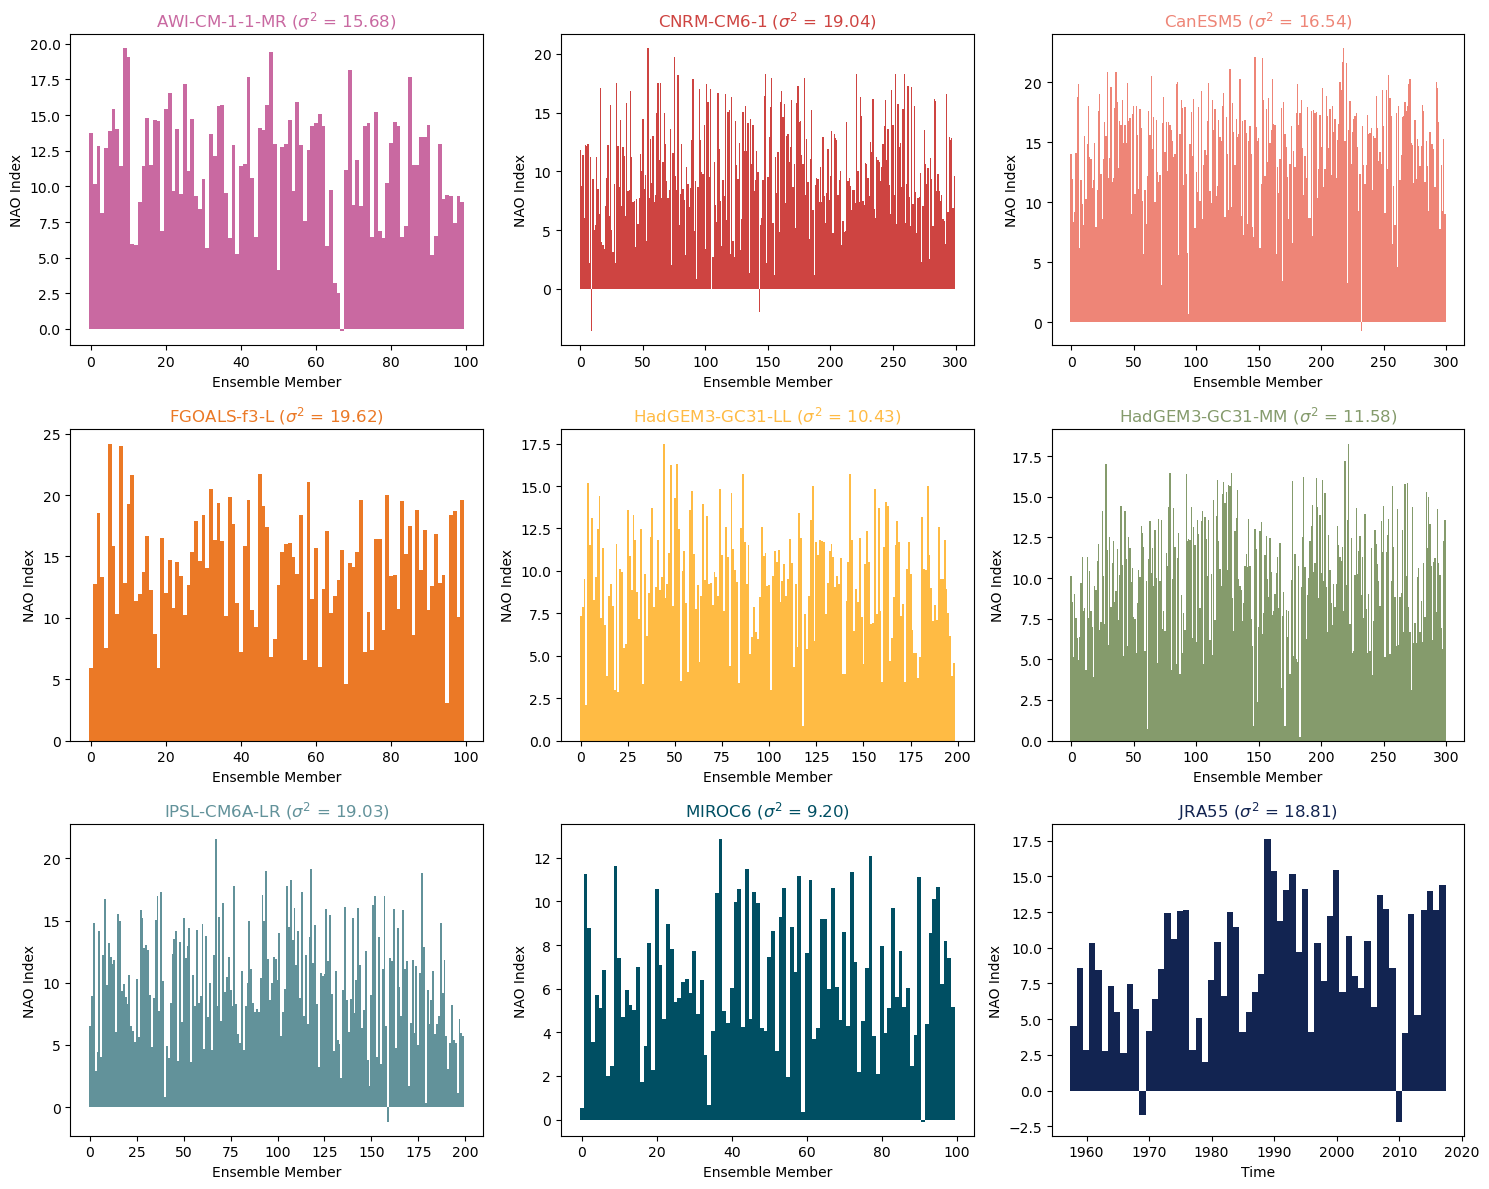

In [6]:
from pypalettes import load_cmap
cmap = load_cmap("Cross")
# Define color palette
color_list = cmap.colors
model_colors = {}


models = list(nao_indices.keys())
n_models = len(models)
cols = 3
rows_grid = int(np.ceil(n_models / cols))


fig, axs = plt.subplots(rows_grid, cols, figsize=(cols * 5, rows_grid * 4))
axs = axs.flatten()

# Assign colors to each model
for i, model in enumerate(models):
    model_colors[model] = color_list[i % len(color_list)]

variance_info = []

for i, model in enumerate(models):
    ax = axs[i]
    nao_data = nao_indices[model]
    
    # X-axis and bar width
    if model == 'JRA55':
        time = nao_data['time']
        width= time[1] - time[0]  # Calculate width based on time intervals
    else:
        time = nao_data['ens_ax']
        width = 1

    # Variance
    variance = float(nao_data.var())
    variance_info.append({'model': model, 'variance': np.round(variance, 2)})

    # Bar color: single color per model
    color = model_colors[model]
    
    # Plot
    ax.bar(time, nao_data, color=color, width=width)
    ax.set_xlabel("Time" if model == 'JRA55' else "Ensemble Member")
    ax.set_ylabel("NAO Index")
    ax.set_title(f"{model} ($\\sigma^2$ = {variance:.2f})", color=color)

# Remove unused axes
for ax in axs[len(models):]:
    fig.delaxes(ax)

fig.tight_layout()
plt.show()


In [7]:
# Convert variance info to DataFrame
df_variance = pd.DataFrame(variance_info)

# # Optionally sort by model or variance
# df_variance = df_variance.sort_values(by='model')

# # Save to CSV
# output_dir = "./data/pamip_misc"  # or your desired directory
# os.makedirs(output_dir, exist_ok=True)
# csv_path = os.path.join(output_dir, "nao_variance_info.csv")
# df_variance.to_csv(csv_path, index=False)

# print(f"Saved variance information to {csv_path}")

# Standardised data

In [15]:
def calculate_nao_index_std(psl, lat_name='lat', lon_name='lon', standardise=False):
    """
    Calculate the NAO index as the difference in area-weighted sea level pressure
    between two regions, with an option to standardise the result.

    Parameters:
    -----------
    psl : xarray.DataArray
        Sea level pressure field.
    lat_name : str
        Name of the latitude coordinate.
    lon_name : str
        Name of the longitude coordinate.
    standardise : bool
        If True, the resulting NAO index will be standardised (mean=0, std=1).

    Returns:
    --------
    xarray.DataArray
        The (optionally standardised) NAO index time series.
    """
    # Longitude wrapping if needed
    if psl[lon_name].max() > 180:
        psl = psl.assign_coords({lon_name: (((psl[lon_name] + 180) % 360) - 180)}).sortby(lon_name)

    # Define boxes
    south_box = psl.sel({lat_name: slice(20, 55), lon_name: slice(-90, 60)})
    north_box = psl.sel({lat_name: slice(55, 90), lon_name: slice(-90, 60)})

    # Area-weighted mean (using cos(lat))
    weights_south = np.cos(np.deg2rad(south_box[lat_name]))
    weights_north = np.cos(np.deg2rad(north_box[lat_name]))

    weights_south, _ = xr.broadcast(weights_south, south_box)
    weights_north, _ = xr.broadcast(weights_north, north_box)

    psl_south = (south_box * weights_south).sum(dim=[lat_name, lon_name]) / weights_south.sum(dim=[lat_name, lon_name])
    psl_north = (north_box * weights_north).sum(dim=[lat_name, lon_name]) / weights_north.sum(dim=[lat_name, lon_name])

    nao_index = psl_south - psl_north

    if standardise:
        if 'ens_ax' in ds.dims:
            nao_index = (nao_index - nao_index.mean(dim='ens_ax')) / nao_index.std(dim='ens_ax')
        else:
            nao_index = (nao_index - nao_index.mean(dim='time')) / nao_index.std(dim='time')

    return nao_index.load()


In [16]:
nao_indices_std = {}
for model_name, ds in mslp.items():
    nao_indices_std[model_name] = calculate_nao_index_std(ds.psl, standardise=True)

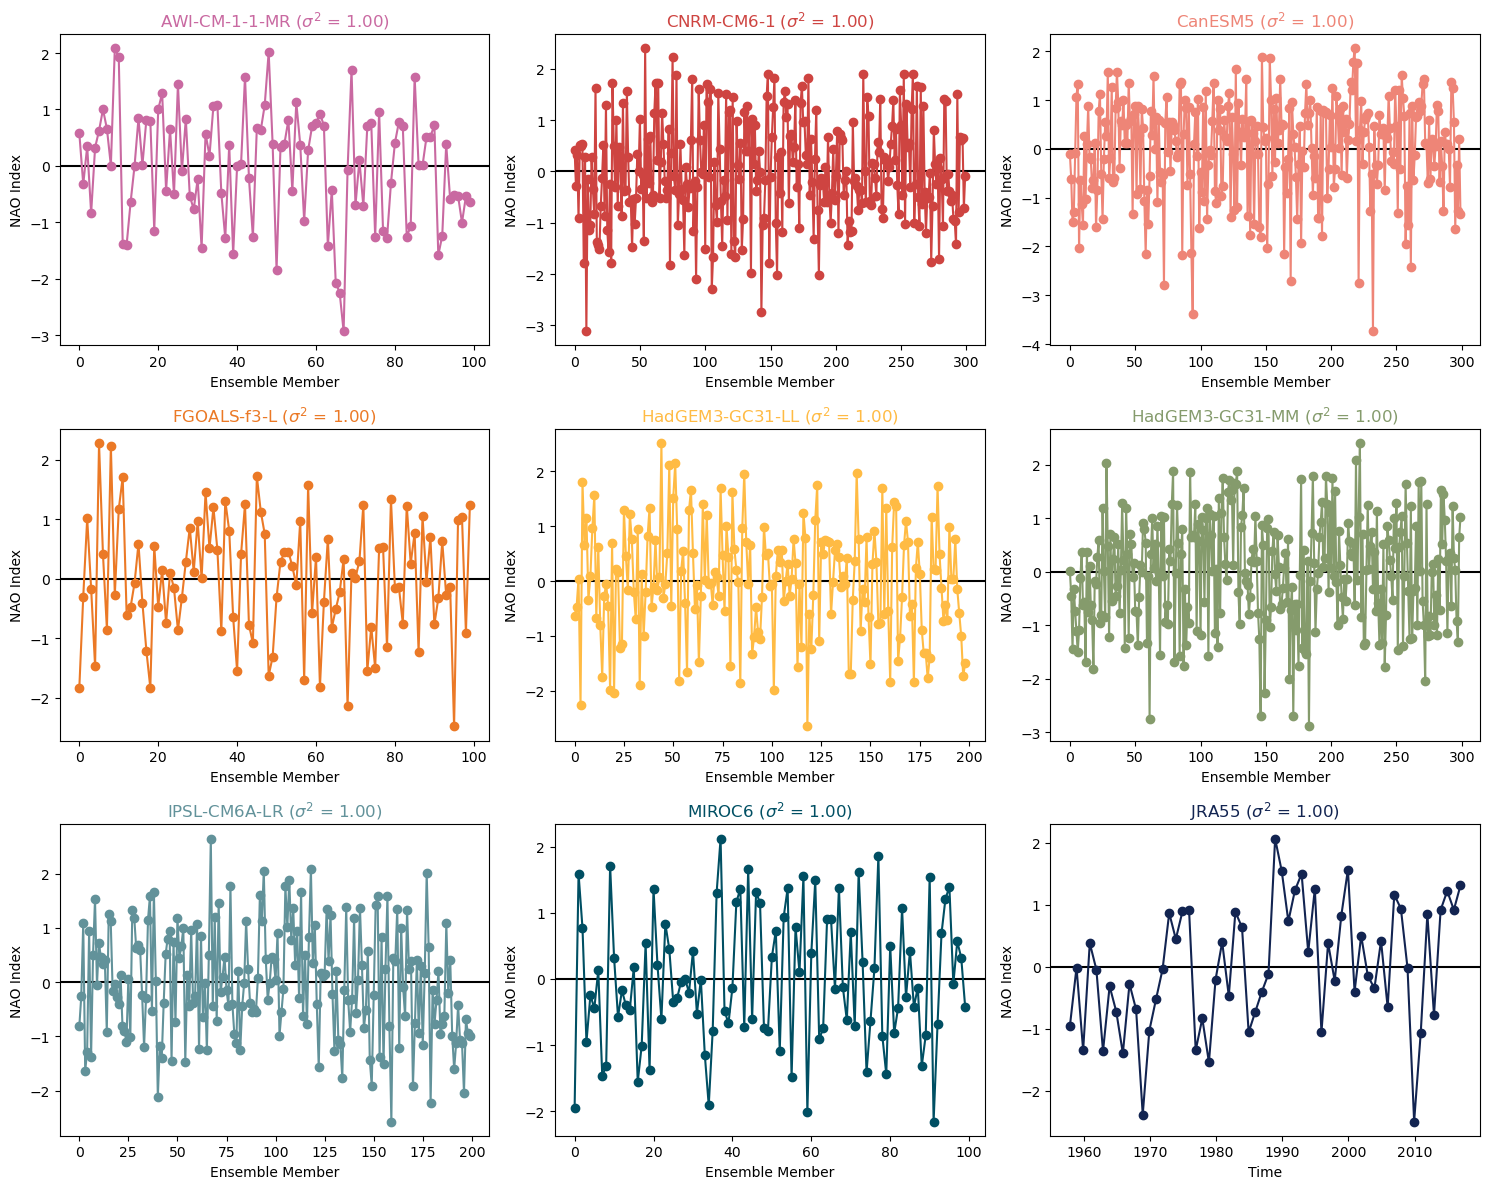

In [20]:
models = list(nao_indices_std.keys())
n_models = len(models)
cols = 3
rows_grid = int(np.ceil(n_models / cols))


fig, axs = plt.subplots(rows_grid, cols, figsize=(cols * 5, rows_grid * 4))
axs = axs.flatten()

# Assign colors to each model
for i, model in enumerate(models):
    model_colors[model] = color_list[i % len(color_list)]

variance_info = []

for i, model in enumerate(models):
    ax = axs[i]
    nao_data = nao_indices_std[model]
    
    # X-axis and bar width
    if model == 'JRA55':
        time = nao_data['time']
        width= time[1] - time[0]  # Calculate width based on time intervals
    else:
        time = nao_data['ens_ax']
        width = 1

    # Variance
    variance = float(nao_data.var())
    variance_info.append({'model': model, 'variance': np.round(variance, 2)})

    # Bar color: single color per model
    color = model_colors[model]
    
    # Plot
    ax.plot(time, nao_data, color=color, marker='o', linewidth=1.5)
    ax.set_xlabel("Time" if model == 'JRA55' else "Ensemble Member")
    ax.set_ylabel("NAO Index")
    ax.set_title(f"{model} ($\\sigma^2$ = {variance:.2f})", color=color)
    
    ax.axhline(y=0, color='k', zorder=-1)

# Remove unused axes
for ax in axs[len(models):]:
    fig.delaxes(ax)

fig.tight_layout()
plt.show()


In [ ]:
models = list(nao_indices_std.keys())
n_models = len(models)
cols = 3
rows_grid = int(np.ceil(n_models / cols))


fig, axs = plt.subplots(rows_grid, cols, figsize=(cols * 5, rows_grid * 4))
axs = axs.flatten()

# Assign colors to each model
for i, model in enumerate(models):
    model_colors[model] = color_list[i % len(color_list)]

variance_info = []

for i, model in enumerate(models):
    ax = axs[i]
    nao_data = nao_indices_std[model]
    
    # X-axis and bar width
    if model == 'JRA55':
        time = nao_data['time']
        width= time[1] - time[0]  # Calculate width based on time intervals
    else:
        time = nao_data['ens_ax']
        width = 1

    # Variance
    variance = float(nao_data.var())
    variance_info.append({'model': model, 'variance': np.round(variance, 2)})

    # Bar color: single color per model
    color = model_colors[model]
    
    # Plot
    ax.plot(time, nao_data, color=color, marker='o', linewidth=1.5)
    ax.set_xlabel("Time" if model == 'JRA55' else "Ensemble Member")
    ax.set_ylabel("NAO Index")
    ax.set_title(f"{model} ($\\sigma^2$ = {variance:.2f})", color=color)
    
    ax.axhline(y=0, color='k', zorder=-1)

# Remove unused axes
for ax in axs[len(models):]:
    fig.delaxes(ax)

fig.tight_layout()
plt.show()
